In [1]:
import pandas as pd
import os

import plotly.express as px

from itables import show

### Load Data

In [3]:
agdatapath = 'CaUsda/CaUsdaFull.csv'
tminpath = 'ClimDivData/climdiv_tmin_cty_clean_trim.csv'
tmaxpath = 'ClimDivData/climdiv_tmax_cty_clean_trim.csv'
tavgpath = 'ClimDivData/climdiv_tavg_cty_clean_trim.csv'
pcpnpath = 'ClimDivData/climdiv_pcpn_cty_clean_trim.csv'
tminstpath = 'ClimDivData/climdiv_tmin_st_clean_trim.csv'
tmaxstpath = 'ClimDivData/climdiv_tmax_st_clean_trim.csv'
tavgstpath = 'ClimDivData/climdiv_tavg_st_clean_trim.csv'
pcpnstpath = 'ClimDivData/climdiv_pcpn_st_clean_trim.csv'

#read tables
agdata_df = pd.read_csv(agdatapath)
tmin_df = pd.read_csv(tminpath)
tmax_df = pd.read_csv(tmaxpath)
tavg_df = pd.read_csv(tavgpath)
pcpn_df = pd.read_csv(pcpnpath)
tmin_st_df = pd.read_csv(tminstpath)
tmax_st_df = pd.read_csv(tmaxstpath)
tavg_st_df = pd.read_csv(tavgstpath)
pcpn_st_df = pd.read_csv(pcpnstpath)

In [4]:
#make full-year amalgamations of data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

pcpn_df['Yearly Precipitation'] = pcpn_df[months].sum(axis=1)
tavg_df['Yearly Average Temperature'] = tavg_df[months].sum(axis=1)/12
tmax_df['Yearly Max Temperature'] = tmax_df[months].max(axis=1)
tmin_df['Yearly Min Temperature'] = tmin_df[months].min(axis=1)

pcpn_st_df['Yearly Precipitation'] = pcpn_st_df[months].sum(axis=1)
tavg_st_df['Yearly Average Temperature'] = tavg_st_df[months].sum(axis=1)/12
tmax_st_df['Yearly Max Temperature'] = tmax_st_df[months].max(axis=1)
tmin_st_df['Yearly Min Temperature'] = tmin_st_df[months].min(axis=1)

In [5]:
show(pcpn_st_df)

### Test crops and counties to help decide what to graph

In [7]:
#see potential crops
crops = list(agdata_df['Crop Name'].unique())
crops.sort()
crops

['ALMONDS ALL',
 'BERRIES STRAWBERRIES FRESH MARKET',
 'CARROTS FRESH MARKET',
 'GRAPES RAISIN',
 'GRAPES WINE',
 'HAY ALFALFA',
 'LETTUCE HEAD',
 'LETTUCE ROMAINE',
 'ORANGES NAVEL',
 'PISTACHIOS',
 'RICE MILLING',
 'TOMATOES PROCESSING']

Graphing is the easiest way to identify top producing counties for later graphs.

In [9]:
#graph crop to see top counties
fig = px.scatter(
    agdata_df[agdata_df['Crop Name'] =='TOMATOES PROCESSING'],
    x='Year',
    y='Production',
    color='County',
)

fig.show()

### Define a couple graphing functions
make_pwt_graph() and make_pw_graph()

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def make_pwt_graph(title, agriculture_df: pd.DataFrame, ag_col: str, crop_name: str, county: list,
                           weather_data: list[list] = [], weather_axis_title="Temperature (°F)",
                           min_year=0, max_year=9999, year_offset=0):
    """
    Graphs production and weather data over time.
    
    Args:
        title: The title of the graph.
        agriculture_df: Agriculture DataFrame. Intended to be the CA Agricultural Commission table from the google drive.
        ag_col: The column to plot on the y-axis (i.e. 'Production', 'Yield', or 'Harvested Acres').
        crop_name: The name of the crop to plot (e.g. 'TOMATOES PROCESSING')
        county: The county whose data to plot. Note that if 'State Total' is set, it will be assumed that the weather
            data will be from the statewide tables, and the state will be set to 'CA'.
        weather_data: This one is a bit complicated. It should consist of a list of lists/tuples in the following
            format: [[weather_df, weather_col, line_color]]
            Each weather_df should be a DataFrame containing data from one of the NOAA weather data tables.
            Each weather_col should be a str indicating the column to use in graphing. Each line_color is the
            color of the line on the graph. line_color is optional and defaults to orange.
        weather_axis_title: Set to specify title of weather axis.
        min_year: Set this if you don't want to show years before a given year.
        max_year: Set this if you don't want to show years after a given year.
        year_offset: Offset the years for weather data by a certain amount to account for delayed effects. The
            offset is added to the title automatically.
    """    
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    if year_offset!=0:
        title += f"<br><sup>Weather Data Offset by {year_offset} Years</sup>"
        
    fig.update_layout(
        title_text=title,
        title_x=0.5,
        width = 1000,
        height = 500
    )
        
    mask = (agriculture_df['Crop Name'] == crop_name) & (agriculture_df['County'] == county) & (agriculture_df['Year']>=min_year) & (agriculture_df['Year']<=max_year)
    ag_mask_df = agriculture_df[mask]
    fig.add_trace(
        go.Scatter(x=ag_mask_df['Year'], y=ag_mask_df[ag_col], name=ag_col, line_color='darkgreen', mode='lines',
                  line=go.scatter.Line(width=2.5)),
        secondary_y=False
    )

    for wdata in weather_data:
        wdf = wdata[0]
        wcol = wdata[1]
        color = "orange" if len(wdata) < 3 else wdata[2]

        #mask by state if using state totals data
        acol = 'State' if county=='State Total' else 'County'
        aval = 'CA' if county=='State Total' else county

        mask = (wdf['Year']>=min_year)&(wdf['Year']<=max_year)&(wdf[acol]==aval)
        wdf = wdf[mask]
        wdf = wdf.copy() 
        wdf['Year'] = wdf.loc[:,'Year']+year_offset

        wtrace = go.Scatter(
            x=wdf['Year'],
            y=wdf[wcol],
            line_color=color,
            opacity=0.5,
            name=wcol, mode='lines',
        )
    
        fig.add_trace(wtrace, secondary_y=True)

    
    fig.update_yaxes(title_text=ag_col, secondary_y=False)
    fig.update_yaxes(title_text=weather_axis_title, secondary_y=True)
        
    
    fig.show()  

In [12]:
def make_pw_graphs(title: str, agriculture_df: pd.DataFrame, ag_col: str, crop_name: str, county: list,
                   weather_data: list = [], min_year=0, max_year=9999, year_offset=0):
    """
    Only maps production against temperature, and only takes one weather_data rather than a list thereof.
    Otherwise basically the same.
    """
    if year_offset!=0:
        title += f"<br><sup>Weather Data Offset by {year_offset} Years</sup>"
        
    mask = (agriculture_df['Crop Name'] == crop_name) & (agriculture_df['County'] == county) & (agriculture_df['Year']>=min_year) & (agriculture_df['Year']<=max_year)
    ag_mask_df = agriculture_df[mask]

    wdf = weather_data[0]
    wcol = weather_data[1]
    wcolor = 'orange' if len(weather_data)<3 else weather_data[2]

    #mask by state if using state totals data
    acol = 'State' if county=='State Total' else 'County'
    aval = 'CA' if county=='State Total' else county

    mask = wdf[acol]==aval
    wdf = wdf[mask]
    wdf = wdf.copy() #being extra careful not to overwrite original df
    wdf.loc[:,'Year'] = wdf['Year']+year_offset
    
    pw_df = pd.merge(ag_mask_df[['Year', ag_col]], wdf[['Year', wcol]], how='inner', on='Year')
    pw_df = pw_df.sort_values(by=wcol)

    fig = px.scatter(
        pw_df,
        x=wcol,
        y=ag_col,
        hover_data='Year',
        trendline='ols'
    )

    fig.update_layout(
        title_text=title,
        title_x=0.5,
    )

    fig.show()

### Tomatoes Processing in Fresno County

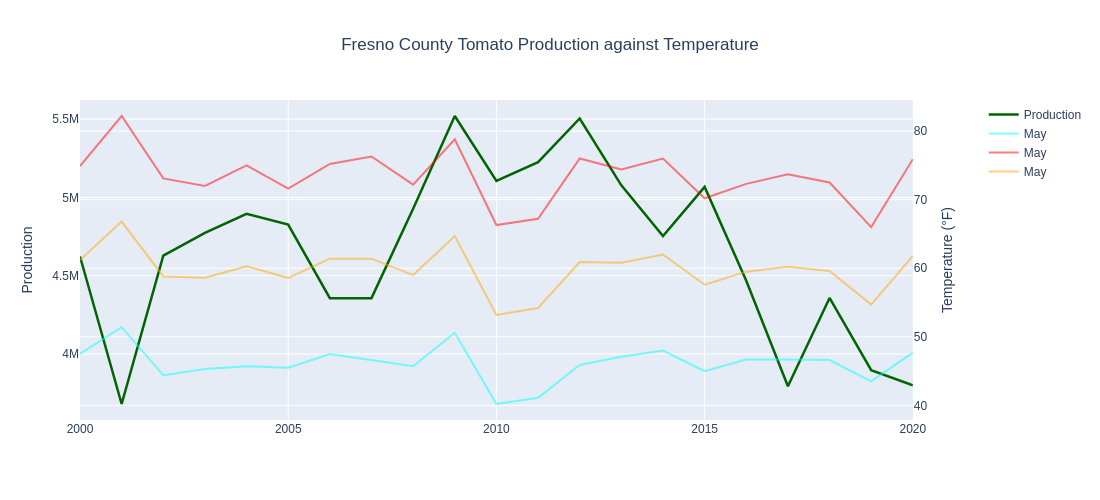

In [76]:
#['Fresno', 'Yolo', 'San Joaquin', 'Kings', 'Stanislaus', 'Colusa']
#targets to graph
tcrop= 'TOMATOES PROCESSING'
tcounty = 'Fresno'

make_pwt_graph(
    title="Fresno County Tomato Production against Temperature",
    agriculture_df = agdata_df,
    ag_col = 'Production',
    crop_name = tcrop,
    county = tcounty,
    weather_data = [[tmin_df, 'May', 'aqua'], [tmax_df, 'May', 'red'], [tavg_df, 'May', 'orange']],
    min_year=2000,
    max_year=2020
)

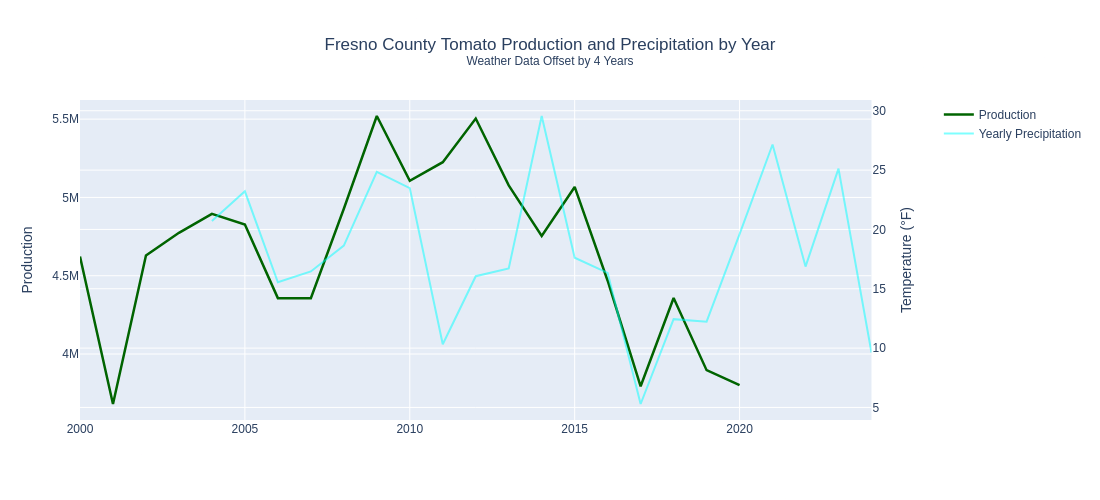

In [77]:
make_pwt_graph(
    title="Fresno County Tomato Production and Precipitation by Year",
    agriculture_df = agdata_df,
    ag_col = 'Production',
    crop_name = tcrop,
    county = tcounty,
    weather_data = [[pcpn_df, 'Yearly Precipitation', 'aqua']],
    min_year=2000,
    max_year=2020,
    year_offset=4
)

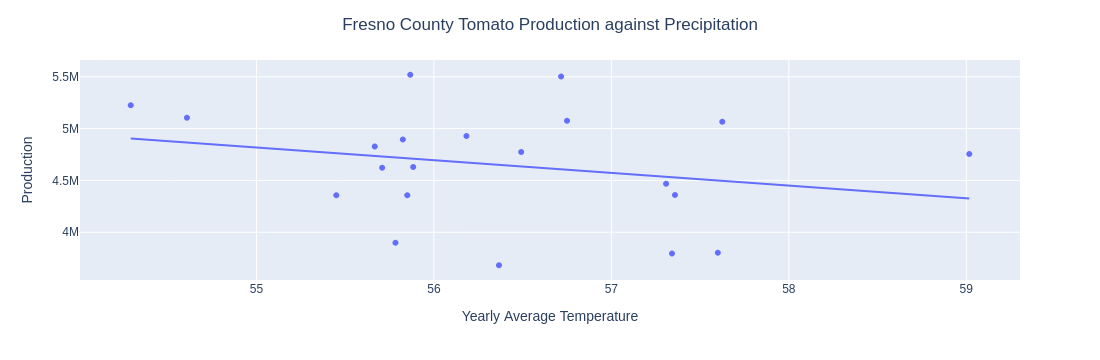

In [79]:
make_pw_graphs(
    title="Fresno County Tomato Production against Precipitation",
    agriculture_df = agdata_df,
    ag_col = 'Production',
    crop_name = tcrop,
    county = tcounty,
    #weather_data = [pcpn_df, 'Yearly Precipitation'],
    weather_data = [tavg_df, 'Yearly Average Temperature'],
    min_year=2000,
    max_year=2020,
    year_offset=0
)

### Tomatoes Processing Statewide

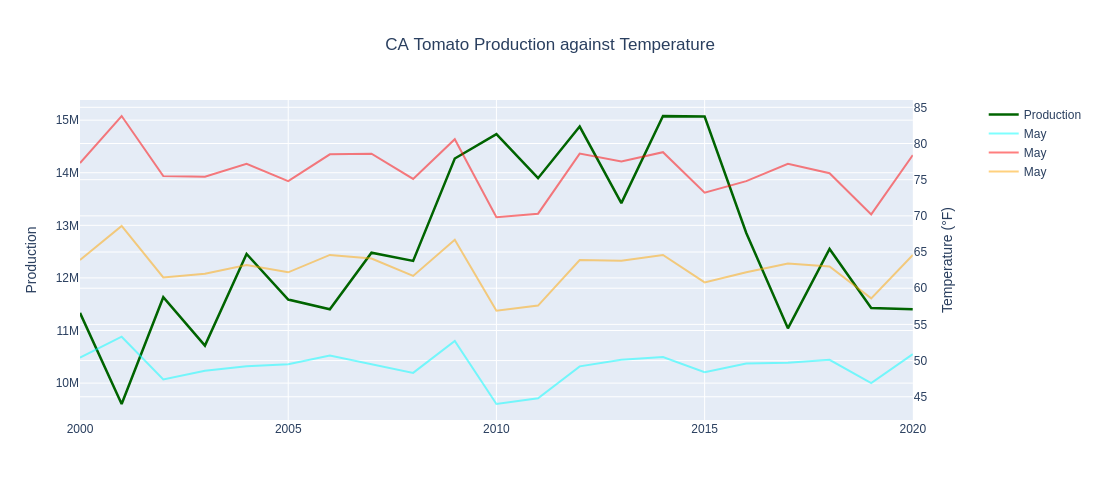

In [60]:
tcrop= 'TOMATOES PROCESSING'
tcounty = 'State Total'

make_pwt_graph(
    title="CA Tomato Production against Temperature",
    agriculture_df = agdata_df,
    ag_col = 'Production',
    crop_name = tcrop,
    county = tcounty,
    weather_data = [[tmin_st_df, 'May', 'aqua'], [tmax_st_df, 'May', 'red'], [tavg_st_df, 'May', 'orange']],
    min_year=2000,
    max_year=2020
)

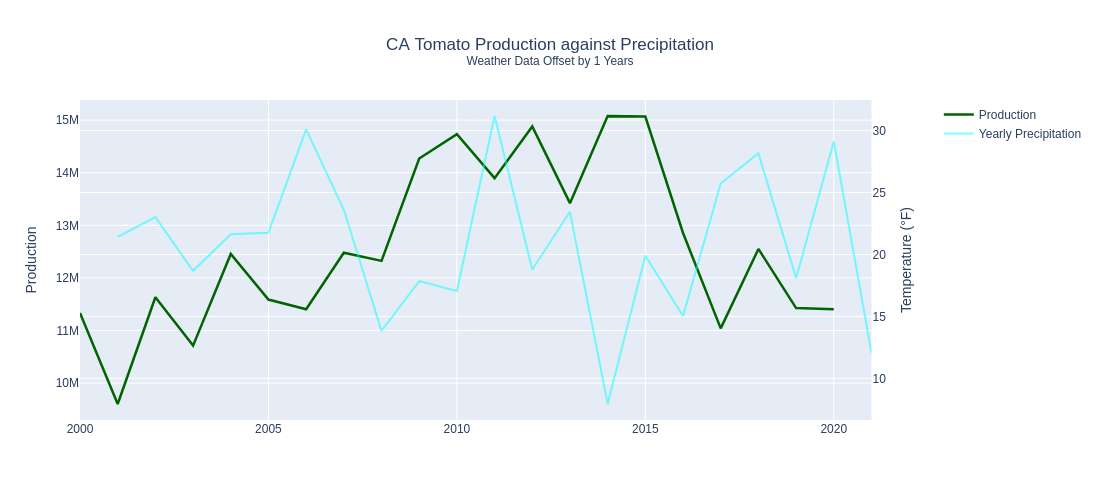

In [68]:
make_pwt_graph(
    title="CA Tomato Production against Precipitation",
    agriculture_df = agdata_df,
    ag_col = 'Production',
    crop_name = tcrop,
    county = tcounty,
    weather_data = [[pcpn_st_df, 'Yearly Precipitation', 'aqua']],
    min_year=2000,
    max_year=2020,
    year_offset=1
)

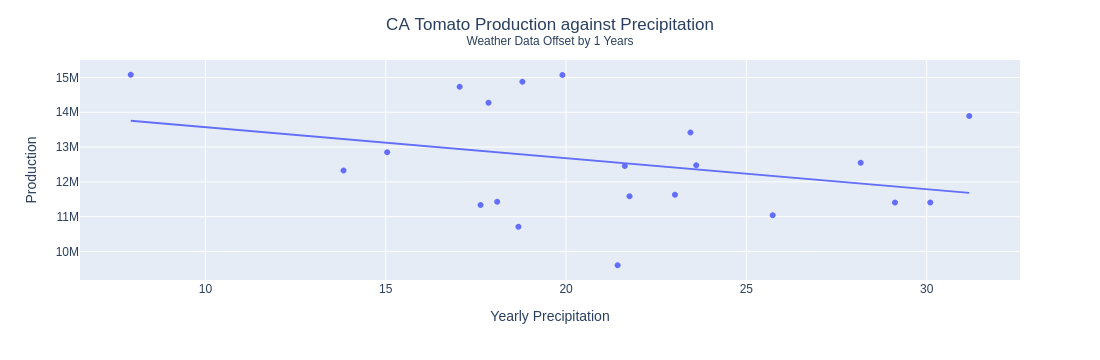

In [72]:
make_pw_graphs(
    title="CA Tomato Production against Precipitation",
    agriculture_df = agdata_df,
    ag_col = 'Production',
    crop_name = tcrop,
    county = tcounty,
    weather_data = [pcpn_st_df, 'Yearly Precipitation'],
    min_year=2000,
    max_year=2020,
    year_offset=1
)

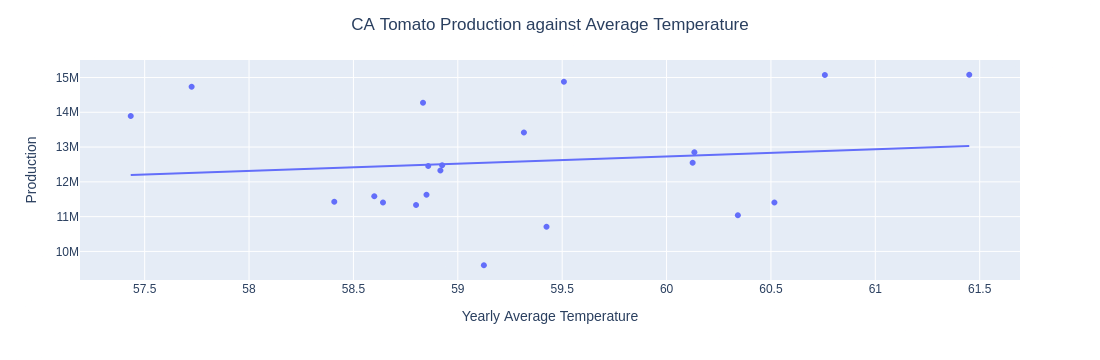

In [21]:
make_pw_graphs(
    title="CA Tomato Production against Average Temperature",
    agriculture_df = agdata_df,
    ag_col = 'Production',
    crop_name = tcrop,
    county = tcounty,
    #weather_data = [pcpn_df, 'Yearly Precipitation'],
    weather_data = [tavg_st_df, 'Yearly Average Temperature'],
    min_year=2000,
    max_year=2020,
    year_offset=0
)

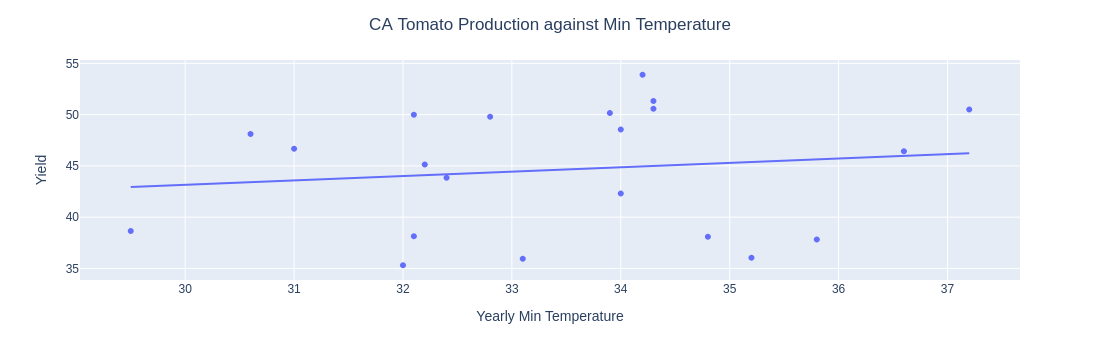

In [22]:
make_pw_graphs(
    title="CA Tomato Production against Min Temperature",
    agriculture_df = agdata_df,
    ag_col = 'Yield',
    crop_name = tcrop,
    county = tcounty,
    weather_data = [tmin_st_df, 'Yearly Min Temperature'],
    min_year=2000,
    max_year=2020,
    year_offset=0
)

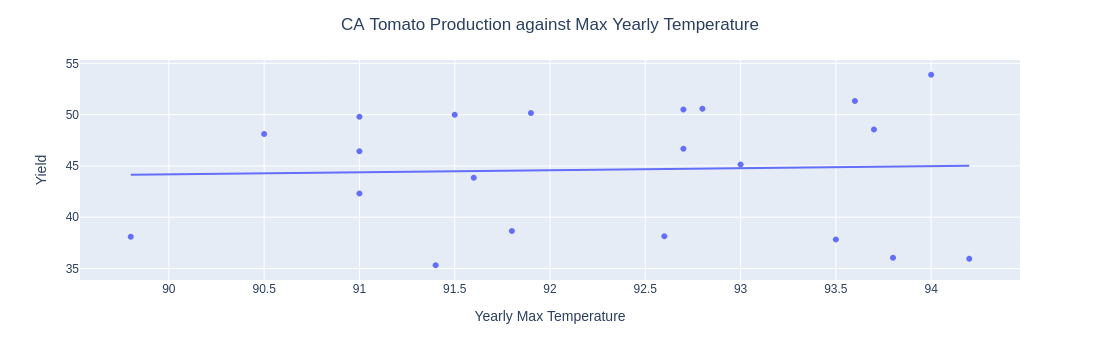

In [66]:
make_pw_graphs(
    title="CA Tomato Production against Max Yearly Temperature",
    agriculture_df = agdata_df,
    ag_col = 'Yield',
    crop_name = tcrop,
    county = tcounty,
    weather_data = [tmax_st_df, 'Yearly Max Temperature'],
    min_year=2000,
    max_year=2020,
    year_offset=0
)